In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [3]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [4]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates

In [5]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [6]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [7]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [8]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [9]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover

In [10]:
HPI_PO

,DATE,YoY,Implied_Turnover
0,1992-01-01,2.35603,NaN
1,1992-04-01,2.14440,NaN
2,1992-07-01,2.77548,NaN
3,1992-10-01,2.74108,NaN
4,1993-01-01,1.53561,NaN
...,...,...,...
116,2021-01-01,13.08681,6.684530
117,2021-04-01,17.81826,6.321918
118,2021-07-01,18.60512,6.440745
119,2021-10-01,17.70045,6.539117


In [11]:
HPI_PO["YoY_MA_5"] = HPI_PO.YoY.rolling(5).mean()

In [12]:
HPI_PO

,DATE,YoY,Implied_Turnover,YoY_MA_5
0,1992-01-01,2.35603,NaN,NaN
1,1992-04-01,2.14440,NaN,NaN
2,1992-07-01,2.77548,NaN,NaN
3,1992-10-01,2.74108,NaN,NaN
4,1993-01-01,1.53561,NaN,2.310520
...,...,...,...,...
116,2021-01-01,13.08681,6.684530,8.903530
117,2021-04-01,17.81826,6.321918,11.219404
118,2021-07-01,18.60512,6.440745,13.788192
119,2021-10-01,17.70045,6.539117,15.676364


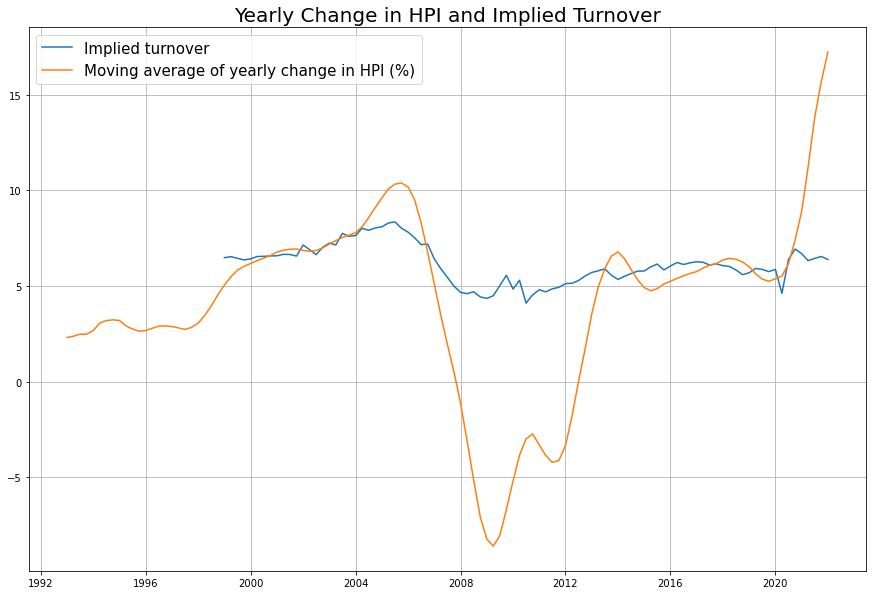

In [13]:
plt.figure(figsize=(15,10))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover.values, label = "Implied turnover")
plt.plot(HPI_PO.DATE, HPI_PO.YoY_MA_5, label = "Moving average of yearly change in HPI (%)")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Yearly Change in HPI and Implied Turnover", size = 20);

In [14]:
HPI_df = HPI_PO.dropna().reset_index(drop=True)

In [15]:
HPI_df

,DATE,YoY,Implied_Turnover,YoY_MA_5
0,1999-01-01,5.93694,6.477936,5.049380
1,1999-04-01,6.02527,6.529750,5.471682
2,1999-07-01,6.29097,6.447134,5.824094
3,1999-10-01,6.14804,6.359195,6.021422
4,2000-01-01,6.46462,6.412796,6.173168
...,...,...,...,...
88,2021-01-01,13.08681,6.684530,8.903530
89,2021-04-01,17.81826,6.321918,11.219404
90,2021-07-01,18.60512,6.440745,13.788192
91,2021-10-01,17.70045,6.539117,15.676364


In [16]:
size=int(HPI_df.shape[0]*0.8)

In [17]:
train, test = HPI_df.iloc[:size,:], HPI_df.iloc[size:,:]

In [18]:
X_train, y_train = train['YoY_MA_5'], train['Implied_Turnover']
X_test, y_test = test['YoY_MA_5'], test['Implied_Turnover']

In [19]:
X_train=np.array(X_train).reshape(-1, 1)
X_test= np.array(X_test).reshape(-1, 1)

In [20]:
from sklearn.linear_model import LinearRegression

# Fit and predict
model = LinearRegression()  
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_fore = model.predict(X_test)

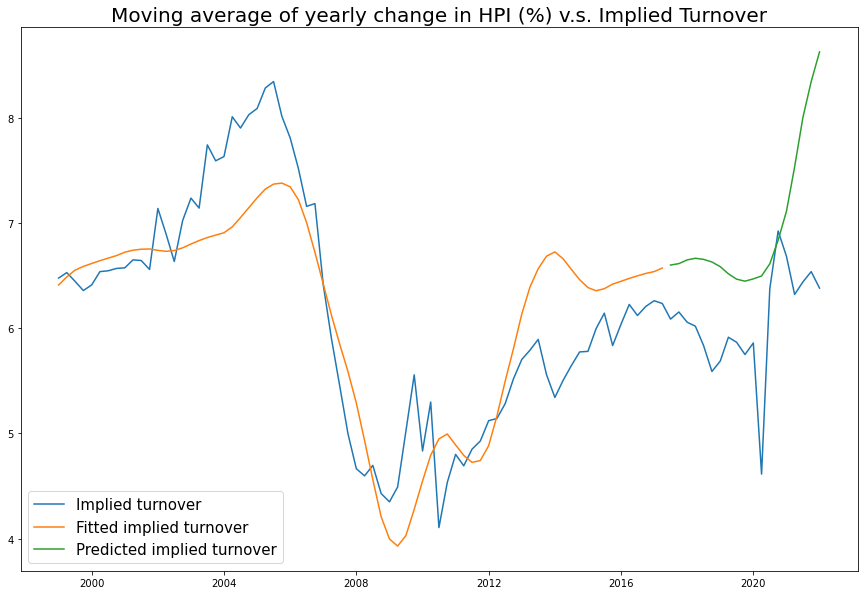

In [23]:
plt.figure(figsize=(15,10))
plt.plot(HPI_df.DATE, HPI_df.Implied_Turnover.values, label = "Implied turnover")
plt.plot(train.DATE, y_pred, label = "Fitted implied turnover")
plt.plot(test.DATE, y_fore, label = "Predicted implied turnover")
plt.legend(fontsize = 15)
plt.title("Moving average of yearly change in HPI (%) v.s. Implied Turnover", size = 20);

Now let us see some statistics results. 

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [27]:
mae = mean_absolute_error(y_test, y_fore)
mse = mean_squared_error(y_test, y_fore)
rmse = np.sqrt(mse)

In [29]:
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 0.89
Mean squared error: 1.13
Root mean squared error: 1.06


Now I am going to include housing credit availability index